In [15]:
pip install scikit-learn-extra

In [16]:
!pip install --quiet pyspark

In [17]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
import sys
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from __future__ import division
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.cluster import KMeans
input = "/content/gdrive/MyDrive/Big Data Project/Customer_data.xlsx"

## Sequential K-Medoid clustering

In [19]:
# Import Python modules
from __future__ import division
import numpy as np
import sklearn.datasets as skl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import timeit

class K_Medoids(object):
    # Initialize input values n_clusters and max_iter
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    # Function that assigns points to a cluster
    def assign_points_to_cluster(self, X):
        # Label points according to the nearest medoid
        self.labels_ = [self._nearest(self.medoids_, x) for x in X]
        # Map labels to data points
        indices = []
        for j in range(self.n_clusters):
            cluster = []
            for i, l in enumerate(self.labels_):
                if l == j:
                    cluster.append(i)
            indices.append(cluster)
        X_by_cluster = [X[i] for i in indices]
        return X_by_cluster

    # Function that randomly selects initial medoids
    def initial_medoid(self, X):
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[initial]

    # Function that updates medoids and repeats
    # assign_points_to_cluster until convergence or max_iter is reached
    def fit(self, X):
        # initialize medoids
        self.medoids_ = self.initial_medoid(X)
        # process of assigning points to clusters until convergence or until max_iter is reached
        for i in range(self.max_iter):
            X_by_cluster = self.assign_points_to_cluster(X)
            # calculate the new medoids
            new_medoids = [self._find_medoid(c) for c in X_by_cluster]
            new_medoids = [arr.tolist() for arr in new_medoids]
            old_medoids = self.medoids_
            # if the new medoids are the same as the old medoids, then the algorithm has converged
            if np.array_equal(new_medoids, old_medoids):
                self.number_of_iter = i
                break
            else:
                # set self.medoids_ as new medoids
                self.medoids_ = new_medoids
        self.number_of_iter = i
        return self

    # Function that finds the medoid in a cluster
    def _find_medoid(self, cluster):
        min_cost = float('inf')
        medoid = None
        for point in cluster:
            cost = sum([self._distance(point, other) for other in cluster])
            if cost < min_cost:
                min_cost = cost
                medoid = point
        return medoid

     # Function that calculates the minimum distance to a medoid
    def _nearest(self, medoids, x):
        return np.argmin([self._distance(x, m) for m in medoids])

    # Function that calculates the Manhattan distance between two points
    def _distance(self, a, b):
        return np.sum(np.abs(a - b))

    # Function that returns predicted clusters for each point
    def predict(self, X):
        return self.labels_



```
# This is formatted as code
```

## Parallelized K-Medoid Clustering

In [20]:
from pyspark import SparkContext, SparkConf

# Stop existing SparkContext
SparkContext.getOrCreate().stop()

conf = SparkConf().setAppName("KMeansClustering").setMaster("local")
sc = SparkContext(conf = conf)

In [21]:
import pandas as pd
import numpy as np
from pyspark import SparkContext
from numpy.linalg import norm
from scipy import spatial
from pyspark.sql import SparkSession
import random

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, ArrayType, DoubleType

def initialize_kmedoids(n_clusters, data, factor=10):
    nb_elements = n_clusters * factor
    sample = data.take(nb_elements)
    rdn_indices = random.sample(range(len(sample)), n_clusters)

    medoids = [(i, sample[index].tolist()) for i, index in enumerate(rdn_indices)]

    spark = SparkSession.builder.getOrCreate()

    # Define the schema for the DataFrame
    schema = StructType([
        StructField("id", IntegerType(), True),
        StructField("medoid", ArrayType(DoubleType()), True)
    ])

    return spark.createDataFrame(medoids, schema)

def compute_distance(point_value, clusters_medoids, metric='manhattan_distance'):
    comp_dist = []
    if metric == 'cos_sim':
        for m in clusters_medoids:
            comp_dist.append(1 - spatial.distance.cosine(np.array(point_value), np.array(m[1])))
    else:
        for m in clusters_medoids:
            comp_dist.append(np.sum(np.abs(np.array(point_value) - np.array(m[1]))))

    return comp_dist

def assign_medoids(points, medoids, sc, metric='manhattan_distance'):
    list_medoids = medoids.collect()
    distances_rdd = points.map(lambda x: compute_distance(x, list_medoids, metric))
    assign_rdd = distances_rdd.map(lambda x: np.argmin(x, axis=0))
    return assign_rdd

def compute_medoids(points, cluster_ids):
    # Function to compute medoids for K-Medoids clustering
    combined_rdd = cluster_ids.zip(points)
    points_by_cluster_id = combined_rdd.groupByKey()

    def find_medoid(points):
        min_distance = float('inf')
        medoid = None
        for point in points:
            distance_sum = sum(np.sum(np.abs(np.array(point) - np.array(other_point))) for other_point in points)
            if distance_sum < min_distance:
                min_distance = distance_sum
                medoid = point

        return medoid
    medoids_rdd = points_by_cluster_id.mapValues(find_medoid)
    return medoids_rdd

def custom_kmedoids(n_clusters, data, factor=15, maxIter=100, metric='manhattan_distance'):
    # Selecting the initial medoids
    medoids = initialize_kmedoids(n_clusters, data, factor)
    stop = False
    i = 0

    while not stop and i < maxIter:
        assigned_medoids = assign_medoids(data, medoids, metric)
        new_medoids = compute_medoids(data, assigned_medoids)

        # Check convergence
        if i == 0:
            prev_medoids_ram = pd.DataFrame([x[1] for x in medoids.collect()])
        else:
            prev_medoids_ram = pd.DataFrame([x[1].tolist() for x in medoids.collect()])
        new_medoids_ram = pd.DataFrame([x[1].tolist() for x in new_medoids.collect()])

        if np.array_equal(new_medoids_ram.values, prev_medoids_ram.values):
            stop = True
        else:
            medoids = new_medoids
            i += 1

    return new_medoids, assigned_medoids, i

## Comparison

In [22]:
data = pd.read_excel(input)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CompanyID              169 non-null    object 
 1   CustomerID             169 non-null    int64  
 2   Age                    169 non-null    int64  
 3   Income                 169 non-null    float64
 4   PurchaseAmount         169 non-null    float64
 5   NumProducts            169 non-null    int64  
 6   SatisfactionScore      169 non-null    int64  
 7   VisitFrequency         169 non-null    float64
 8   CustomerLifetimeValue  169 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 12.0+ KB


In [23]:
del data["CompanyID"]
del data["CustomerID"]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    169 non-null    int64  
 1   Income                 169 non-null    float64
 2   PurchaseAmount         169 non-null    float64
 3   NumProducts            169 non-null    int64  
 4   SatisfactionScore      169 non-null    int64  
 5   VisitFrequency         169 non-null    float64
 6   CustomerLifetimeValue  169 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 9.4 KB


In [24]:
data.describe()

,Age,Income,PurchaseAmount,NumProducts,SatisfactionScore,VisitFrequency,CustomerLifetimeValue
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,41.153846,60821.573145,255.678530,2.325444,5.597633,2.894490,2993.480507
std,13.752922,23583.411633,146.447068,1.131530,2.903855,1.207716,1213.373202
min,18.000000,20187.151250,10.381595,1.000000,1.000000,0.554695,564.770699
25%,30.000000,38485.983727,133.206795,1.000000,3.000000,1.953304,2019.268271
50%,42.000000,62211.818412,253.651768,2.000000,5.000000,2.904558,3025.747389
75%,53.000000,80049.180131,391.500250,3.000000,8.000000,3.910307,4074.302525
max,64.000000,99700.295981,493.243265,4.000000,10.000000,4.940991,4989.616772


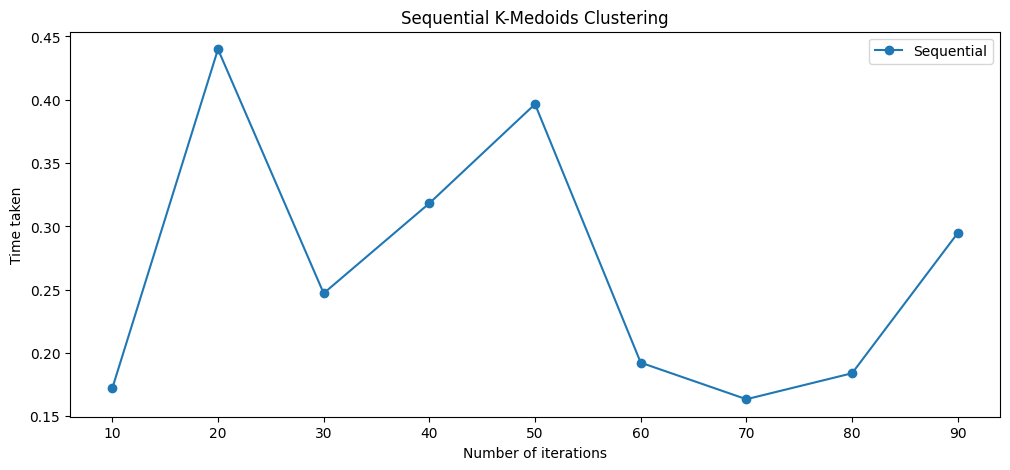

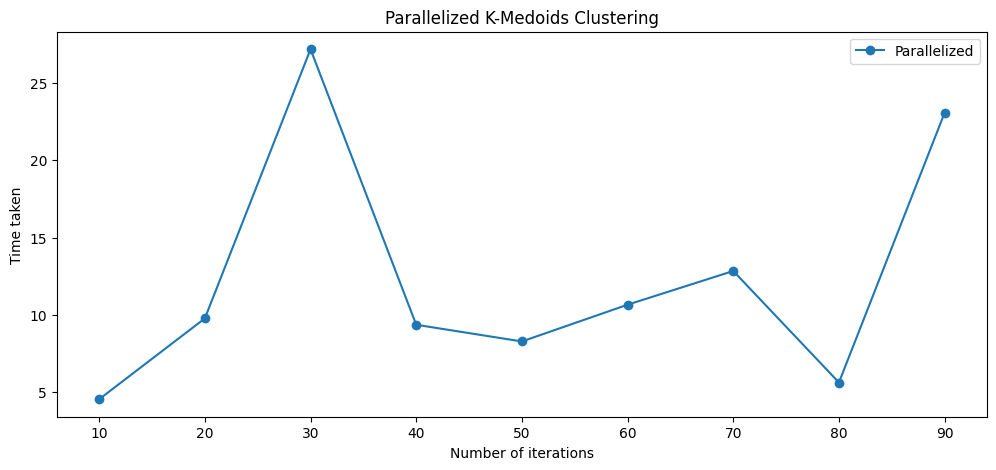

In [25]:
import time
import matplotlib.pyplot as plt

# Assuming X and itr are defined
X = data.to_numpy()
itr = np.arange(10, 100, 10)
t_ser = []
t_par = []

# Serial version
for i in itr:
    t1 = time.time()
    k_medoids = K_Medoids(n_clusters=4, max_iter=i)
    y = k_medoids.fit(X)
    t2 = time.time() - t1
    t_ser.append(t2)

# Parallelized version
rdd = sc.parallelize(X)
for i in itr:
    t1 = time.time()
    new_medoids, assigned_clusters, convergence_iter = custom_kmedoids(n_clusters=4, data=rdd, maxIter=i)
    t2 = time.time() - t1
    t_par.append(t2)


plt.figure(figsize=(12, 5))
plt.plot(itr, t_ser, '-o', label="Sequential")
plt.title('Sequential K-Medoids Clustering')
plt.xlabel('Number of iterations')
plt.ylabel('Time taken')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(itr, t_par, '-o', label="Parallelized")
plt.title('Parallelized K-Medoids Clustering')
plt.xlabel('Number of iterations')
plt.ylabel('Time taken')
plt.legend()
plt.show()

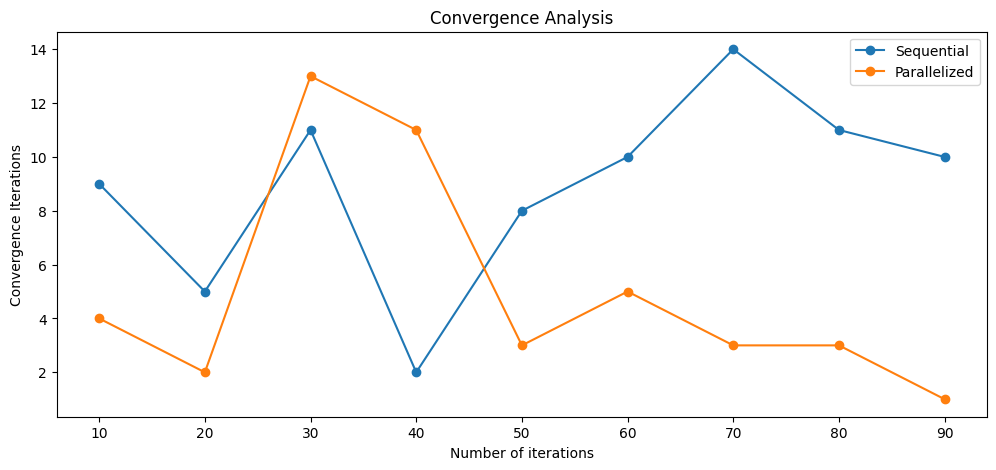

In [26]:
converged_ser = [K_Medoids(4, i).fit(X).number_of_iter for i in itr]
converged_par = [custom_kmedoids(n_clusters=4, data=rdd, maxIter=i)[2] for i in itr]

plt.figure(figsize=(12, 5))
plt.plot(itr, converged_ser, '-o', label="Sequential")
plt.plot(itr, converged_par, '-o', label="Parallelized")
plt.title('Convergence Analysis')
plt.xlabel('Number of iterations')
plt.ylabel('Convergence Iterations')
plt.legend()
plt.show()

In [27]:
# Your existing code
X = data.to_numpy()

# Sequential version
t1 = time.time()
KmeansSer = K_Medoids(4, 1000)
y = KmeansSer.fit(X)
t2 = time.time() - t1
data['Label_Seq'] = y.labels_

# Parallelized version
t3 = time.time()
rdd = sc.parallelize(X)
new_medoids, assigned_clusters, convergence_iter = custom_kmedoids(n_clusters=4, data=rdd, maxIter=1000)
t4 = time.time() - t3
data['Label_Par'] = assigned_clusters.collect()

# Print the time taken for both versions
print("Sequential Time:", t2)
print("Parallelized Time:", t4)

Sequential Time: 0.388383150100708
Parallelized Time: 20.890857934951782


In [28]:
from sklearn import metrics

print("Performance of Sequential algorithm : ",metrics.silhouette_score(X,data['Label_Seq']))
print("Performance of Parallel algorithm : ",metrics.silhouette_score(X,data['Label_Par']))

Performance of Sequential algorithm :  0.584850473448339
Performance of Parallel algorithm :  0.5960215310575627
